时间序列数据的意义取决于具体的应用场景，主要有以下几种：

> * 时间戳（timestamp），特定的时刻。
> * 固定时期（period），如2007年1月或2010年全年。
> * 时间间隔（interval），由起始和结束时间戳表示。时期（period）可以被看做间隔（interval）的特例。
> * 实验或过程时间，每个时间点都是相对于特定起始时间的一个度量。例如，从放入烤箱时起，每秒钟饼干的直径。

本章主要讲解前3种时间序列。许多技术都可用于处理实验型时间序列，其索引可能是一个整数或浮点数（表示从实验开始算起已经过去的时间）。最简单也最常见的时间序列都是用时间戳进行索引的。

# 11.1 日期和时间数据类型及工具-----------------------------------------------------------------

Python标准库包含用于日期（date）和时间（time）数据的数据类型，而且还有日历方面的功能。我们主要会用到datetime、time以及calendar模块。datetime.datetime（也可以简写为datetime）是用得最多的数据类型：

datetime以毫秒形式存储日期和时间。timedelta表示两个datetime对象之间的时间差：

可以给datetime对象加上（或减去）一个或多个timedelta，这样会产生一个新对象：

> datetime模块中的数据类型参见表10-1。

> date | time | datetime存储日期和时间 | timedelta表示两个datetime之间的差（日、秒、毫秒） | tizinfo |

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

now = datetime.now()
now

datetime.datetime(2018, 8, 9, 23, 8, 6, 365388)

In [2]:
delta = datetime(2011, 1, 7) - datetime(2008, 6, 24, 8, 15)
delta

datetime.timedelta(926, 56700)

# 字符串和datetime的相互转换

利用**str或strftime方法**（传入一个格式化字符串），datetime对象和pandas的Timestamp对象（稍后就会介绍）可以被格式化为字符串：

**datetime.strptime方法**可以用这些格式化编码将字符串转换为日期：

datetime.strptime是通过已知格式进行日期解析的最佳方式。但是每次都要编写格式定义是很麻烦的事情，尤其是对于一些常见的日期格式。这种情况下，你可以用**dateutil库**这个第三方包中的**parser.parse方法**（pandas中已经自动安装好了）：

dateutil可以解析几乎所有人类能够理解的日期表示形式：

在国际通用的格式中，日出现在月的前面很普遍，传入**参数dayfirst**=True即可解决这个问题：

pandas通常是用于处理成组日期的，不管这些日期是DataFrame的轴索引还是列。**to_datetime方法**可以解析多种不同的日期表示形式。对标准日期格式（如ISO8601）的解析非常快：

它还可以处理缺失值（None、空字符串等）：【转换为**NaT**（Not a Time）是pandas中时间戳数据的null值。】

In [3]:
stamp = datetime(2011,1,3)
print(str(stamp))
stamp.strftime('%Y-%m-%d')

2011-01-03 00:00:00


'2011-01-03'

In [4]:
value = '2011-01-03'
datetime.strptime(value, '%Y-%m-%d')

datetime.datetime(2011, 1, 3, 0, 0)

In [5]:
from dateutil.parser import parse
parse(value)

datetime.datetime(2011, 1, 3, 0, 0)

In [6]:
datestrs = ['2011-07-06 12:00:00', '2011-08-06 00:00:00']

pd.to_datetime(datestrs)

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00'], dtype='datetime64[ns]', freq=None)

In [7]:
idx = pd.to_datetime(datestrs + [None])
idx

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00', 'NaT'], dtype='datetime64[ns]', freq=None)

# 11.2 时间序列基础------------------------------------------------------------------------------------

pandas最基本的时间序列类型就是以时间戳（通常以Python字符串或datatime对象表示）为索引的Series：

这些datetime对象实际上是被放在一个DatetimeIndex中的：

跟其他Series一样，不同索引的时间序列之间的算术运算会自动按日期对齐：

pandas用NumPy的datetime64数据类型以纳秒形式存储时间戳：

DatetimeIndex中的各个标量值是pandas的**Timestamp对象**：只要有需要，TimeStamp可以随时自动转换为datetime对象。此外，它还可以存储频率信息（如果有的话），且知道如何执行时区转换以及其他操作。稍后将对此进行详细讲解。

In [8]:
from datetime import datetime
dates = [datetime(2011, 1, 2), datetime(2011, 1, 5),
         datetime(2011, 1, 7), datetime(2011, 1, 8),
         datetime(2011, 1, 10), datetime(2011, 1, 12)]

ts = pd.Series(np.random.randn(6), index=dates)
ts

2011-01-02    1.139026
2011-01-05    1.721064
2011-01-07   -0.470355
2011-01-08   -1.683994
2011-01-10    0.224382
2011-01-12   -0.526094
dtype: float64

In [9]:
ts.index

DatetimeIndex(['2011-01-02', '2011-01-05', '2011-01-07', '2011-01-08',
               '2011-01-10', '2011-01-12'],
              dtype='datetime64[ns]', freq=None)

In [10]:
ts+ts[::2]    # 算术运算的含义

2011-01-02    2.278053
2011-01-05         NaN
2011-01-07   -0.940711
2011-01-08         NaN
2011-01-10    0.448764
2011-01-12         NaN
dtype: float64

In [11]:
ts.index[0]

Timestamp('2011-01-02 00:00:00')

# 索引、选取、子集构造 Indexing, Selection, Subsetting

当你根据**标签索引**选取数据时，时间序列和其它的pandas.Series很像：

还有一种更为方便的用法：传入一个可以被解释为日期的字符串：

【**重要技巧**：使用低频索引，会得到切片】对于较长的时间序列，只需传入“年”或“年月”即可轻松选取数据的切片：

这里，字符串“2001”被解释成年，并根据它选取时间区间。指定月也同样奏效：

In [12]:
stamp = ts.index[2]
ts[stamp]

-0.47035538986454928

In [13]:
ts['2011-01-05']

1.7210638728384273

In [14]:
longer_ts = pd.Series(np.random.randn(1000),
                      index=pd.date_range('1/1/2000', periods=1000))
longer_ts['2001']

2001-01-01   -0.325859
2001-01-02   -1.443464
2001-01-03    0.215332
2001-01-04    0.119814
2001-01-05   -0.674215
2001-01-06    0.060077
2001-01-07   -1.645250
2001-01-08    0.429476
2001-01-09    0.572461
2001-01-10   -1.533112
2001-01-11    0.743151
2001-01-12   -0.160694
2001-01-13   -0.584646
2001-01-14    0.947854
2001-01-15    1.988745
2001-01-16   -0.485307
2001-01-17   -0.611061
2001-01-18    0.625170
2001-01-19   -0.494131
2001-01-20   -0.329138
2001-01-21    0.297205
2001-01-22    0.360824
2001-01-23   -0.810563
2001-01-24    2.014809
2001-01-25   -1.492281
2001-01-26   -0.212061
2001-01-27   -0.570404
2001-01-28    0.873674
2001-01-29   -0.791464
2001-01-30    0.112121
                ...   
2001-12-02    0.598898
2001-12-03   -0.879108
2001-12-04    0.470832
2001-12-05    1.408802
2001-12-06    1.006550
2001-12-07    0.442018
2001-12-08   -1.695335
2001-12-09    0.724897
2001-12-10    0.615737
2001-12-11    0.175772
2001-12-12    0.469678
2001-12-13   -0.312320
2001-12-14 

In [15]:
longer_ts['2001-05']

2001-05-01    1.102120
2001-05-02    0.310616
2001-05-03    0.523124
2001-05-04   -0.905261
2001-05-05    0.296669
2001-05-06   -0.712176
2001-05-07    0.231759
2001-05-08   -1.496655
2001-05-09   -3.515578
2001-05-10    1.900601
2001-05-11   -0.501136
2001-05-12   -1.235296
2001-05-13    0.508819
2001-05-14    0.433955
2001-05-15   -1.599005
2001-05-16    0.010882
2001-05-17    0.207622
2001-05-18   -0.670139
2001-05-19   -0.191262
2001-05-20    0.832879
2001-05-21    1.665952
2001-05-22   -1.162772
2001-05-23    0.391370
2001-05-24   -1.087025
2001-05-25    0.340714
2001-05-26    0.085025
2001-05-27   -0.049452
2001-05-28    0.244245
2001-05-29    0.399409
2001-05-30    0.432518
2001-05-31    0.161575
Freq: D, dtype: float64

datetime对象也可以进行切片：

【**范围切片**】

由于大部分时间序列数据都是按照时间先后排序的，因此你也可以用不存在于该时间序列中的时间戳对其进行切片（即范围查询）：

跟之前一样，你可以传入字符串日期、datetime或Timestamp。注意，这样切片所产生的是原时间序列的视图，跟NumPy数组的切片运算是一样的。

这意味着，没有数据被复制，对切片进行修改会反映到原始数据上。

此外，还有一个等价的实例**方法truncate**也可以截取两个日期之间TimeSeries：

上面这些操作对DataFrame也有效。例如，对DataFrame的行进行索引：

In [16]:
ts[datetime(2011,1,7):]

2011-01-07   -0.470355
2011-01-08   -1.683994
2011-01-10    0.224382
2011-01-12   -0.526094
dtype: float64

In [17]:
ts['1/6/2011':'1/11/2011']

2011-01-07   -0.470355
2011-01-08   -1.683994
2011-01-10    0.224382
dtype: float64

In [18]:
ts.truncate(after='1/9/2011')

2011-01-02    1.139026
2011-01-05    1.721064
2011-01-07   -0.470355
2011-01-08   -1.683994
dtype: float64

In [19]:
dates = pd.date_range('1/1/2000', periods=100, freq='W-WED')
long_df = pd.DataFrame(np.random.randn(100, 4),
                       index=dates,
                       columns=['Colorado', 'Texas','New York', 'Ohio'])
long_df.loc['5-2001']

,Colorado,Texas,New York,Ohio
2001-05-02,0.036295,0.753952,0.714551,1.244729
2001-05-09,-0.143465,-0.056395,-0.701543,0.214982
2001-05-16,-0.968706,-0.031546,1.879978,-0.746652
2001-05-23,-3.463471,0.235300,0.570709,-0.162185
2001-05-30,0.306815,0.112487,-0.108616,0.682038


# 带有重复索引的时间序列

在某些应用场景中，可能会存在多个观测数据落在同一个时间点上的情况。下面就是一个例子：

通过检查索引的**is_unique属性**，我们就可以知道它是不是唯一的：

对这个时间序列进行索引，要么产生标量值，要么产生切片，具体要看所选的时间点是否重复：

假设你想要对具有非唯一时间戳的数据进行聚合。一个办法是使用groupby，并传入level=0：

In [20]:
dates = pd.DatetimeIndex(['1/1/2000', '1/2/2000', '1/2/2000',
                          '1/2/2000', '1/3/2000'])
dup_ts = pd.Series(np.arange(5), index=dates)
dup_ts.index.is_unique

False

In [21]:
dup_ts['1/2/2000']

2000-01-02    1
2000-01-02    2
2000-01-02    3
dtype: int32

In [22]:
grouped = dup_ts.groupby(by=dup_ts.index)
grouped.size()

2000-01-01    1
2000-01-02    3
2000-01-03    1
dtype: int64

# 11.3 日期的范围、频率以及移动 Date Ranges, Frequencies, and Shifting--------

pandas中的原生时间序列一般被认为是不规则的，也就是说，它们没有固定的频率。对于大部分应用程序而言，这是无所谓的。但是，它常常需要以某种相对固定的频率进行分析，比如每日、每月、每15分钟等（这样自然会在时间序列中引入缺失值）。幸运的是，pandas有一整套标准时间序列频率以及用于重采样、频率推断、生成固定频率日期范围的工具。

例如，我们可以将之前那个时间序列转换为一个具有固定频率（每日）的时间序列，只需调用**resample方法**即可：
```
Signature: ts.resample(rule, how=None, axis=0, fill_method=None, closed=None, label=None, convention='start', kind=None, loffset=None, limit=None, base=0, on=None, level=None)
```

In [23]:
ts

2011-01-02    1.139026
2011-01-05    1.721064
2011-01-07   -0.470355
2011-01-08   -1.683994
2011-01-10    0.224382
2011-01-12   -0.526094
dtype: float64

In [24]:
resampler = ts.resample('D')
resampler

DatetimeIndexResampler [freq=<Day>, axis=0, closed=left, label=left, convention=start, base=0]

# 生成日期范围

虽然我之前用的时候没有明说，但你可能已经猜到**pandas.date_range**可用于根据指定的频率生成指定长度的DatetimeIndex：
```
Signature: pd.date_range(start=None, end=None, periods=None, freq='D', tz=None, normalize=False, name=None, closed=None, **kwargs)
```

默认情况下，date_range会产生按天计算的时间点。如果只传入起始或结束日期，那就还得传入一个表示一段时间的数字：

起始和结束日期定义了日期索引的严格边界。例如，如果你想要生成一个由每月最后一个工作日组成的日期索引，可以传入"BM"频率（表示business end of month）这样就只会包含时间间隔内（或刚好在边界上的）符合频率要求的日期：

> 表11-4 基本的时间序列频率（不完整）**参数freq**

> D B每工作日 | H | T或min | S | L或ms | U每微秒 | M每月最后一个日历日 | BM每月最后一个工作日 | MS BMS | W-MON每周指定周几 |

> 其它

date_range**默认会保留起始和结束时间戳**的时间信息（如果有的话）：

有时，虽然起始和结束日期带有时间信息，但你希望产生一组被规范化（**参数normalize**）到午夜的时间戳。normalize选项即可实现该功能：

In [25]:
index = pd.date_range('2012-04-01', '2012-06-01')
index

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20',
               '2012-04-21', '2012-04-22', '2012-04-23', '2012-04-24',
               '2012-04-25', '2012-04-26', '2012-04-27', '2012-04-28',
               '2012-04-29', '2012-04-30', '2012-05-01', '2012-05-02',
               '2012-05-03', '2012-05-04', '2012-05-05', '2012-05-06',
               '2012-05-07', '2012-05-08', '2012-05-09', '2012-05-10',
               '2012-05-11', '2012-05-12', '2012-05-13', '2012-05-14',
               '2012-05-15', '2012-05-16', '2012-05-17', '2012-05-18',
               '2012-05-19', '2012-05-20', '2012-05-21', '2012-05-22',
               '2012-05-23', '2012-05-24', '2012-05-25', '2012-05-26',
      

In [26]:
pd.date_range(start='2012-04-01', periods=20)

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20'],
              dtype='datetime64[ns]', freq='D')

In [27]:
pd.date_range(end='2012-06-01', periods=20)

DatetimeIndex(['2012-05-13', '2012-05-14', '2012-05-15', '2012-05-16',
               '2012-05-17', '2012-05-18', '2012-05-19', '2012-05-20',
               '2012-05-21', '2012-05-22', '2012-05-23', '2012-05-24',
               '2012-05-25', '2012-05-26', '2012-05-27', '2012-05-28',
               '2012-05-29', '2012-05-30', '2012-05-31', '2012-06-01'],
              dtype='datetime64[ns]', freq='D')

In [28]:
pd.date_range('2000-01-01', '2000-12-01', freq='BM')

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-28',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-29', '2000-10-31', '2000-11-30'],
              dtype='datetime64[ns]', freq='BM')

In [29]:
pd.date_range('2012-05-02 12:56:31', periods=5)

DatetimeIndex(['2012-05-02 12:56:31', '2012-05-03 12:56:31',
               '2012-05-04 12:56:31', '2012-05-05 12:56:31',
               '2012-05-06 12:56:31'],
              dtype='datetime64[ns]', freq='D')

In [30]:
pd.date_range('2012-05-02 12:56:31', periods=5, normalize=True)

DatetimeIndex(['2012-05-02', '2012-05-03', '2012-05-04', '2012-05-05',
               '2012-05-06'],
              dtype='datetime64[ns]', freq='D')

# 频率和日期偏移量 Frequencies and Date Offsets

pandas中的频率是由一个基础频率（base frequency）和一个乘数组成的。基础频率通常以一个字符串别名表示，比如"M"表示每月，"H"表示每小时。对于每个基础频率，都有一个被称为日期偏移量（date offset）的对象与之对应。例如，按小时计算的频率可以用Hour类表示：

【**pandas.tseries.offsets模块**】

传入一个整数即可定义偏移量的倍数：

一般来说，无需明确创建这样的对象，只需使用诸如"H"或"4H"这样的字符串别名即可。在基础频率前面放上一个整数即可创建倍数：

大部分偏移量对象都可通过加法进行连接：同理，你也可以传入**频率字符串**（如"2h30min"），这种字符串可以被高效地解析为等效的表达式：

有些频率所描述的时间点并不是均匀分隔的。例如，"M"（日历月末）和"BM"（每月最后一个工作日）就取决于每月的天数，对于后者，还要考虑月末是不是周末。由于没有更好的术语，我将这些称为锚点偏移量（anchored offset）。

In [31]:
from pandas.tseries.offsets import Hour, Minute
four_hours = Hour(4)
type(four_hours)

pandas.tseries.offsets.Hour

In [32]:
pd.date_range('2000-01-01', '2000-01-03 23:59', freq='4h')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 04:00:00',
               '2000-01-01 08:00:00', '2000-01-01 12:00:00',
               '2000-01-01 16:00:00', '2000-01-01 20:00:00',
               '2000-01-02 00:00:00', '2000-01-02 04:00:00',
               '2000-01-02 08:00:00', '2000-01-02 12:00:00',
               '2000-01-02 16:00:00', '2000-01-02 20:00:00',
               '2000-01-03 00:00:00', '2000-01-03 04:00:00',
               '2000-01-03 08:00:00', '2000-01-03 12:00:00',
               '2000-01-03 16:00:00', '2000-01-03 20:00:00'],
              dtype='datetime64[ns]', freq='4H')

In [33]:
Hour(4) + Minute(30)

<270 * Minutes>

In [34]:
pd.date_range('2000-1-1', periods=10, freq='1h30min')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 01:30:00',
               '2000-01-01 03:00:00', '2000-01-01 04:30:00',
               '2000-01-01 06:00:00', '2000-01-01 07:30:00',
               '2000-01-01 09:00:00', '2000-01-01 10:30:00',
               '2000-01-01 12:00:00', '2000-01-01 13:30:00'],
              dtype='datetime64[ns]', freq='90T')

### WOM日期

WOM（Week Of Month）是一种非常实用的频率类，它以WOM开头。它使你能获得诸如“每月第3个星期五”之类的日期：

In [35]:
rng = pd.date_range('2012-01-01', '2012-09-01', freq='WOM-3FRI')
rng

DatetimeIndex(['2012-01-20', '2012-02-17', '2012-03-16', '2012-04-20',
               '2012-05-18', '2012-06-15', '2012-07-20', '2012-08-17'],
              dtype='datetime64[ns]', freq='WOM-3FRI')

# 移动（超前和滞后）数据 Shifting (Leading and Lagging) Data

移动（shifting）指的是沿着时间轴将数据前移或后移。Series和DataFrame都有一个**shift方法**用于执行单纯的前移或后移操作，保持索引不变：
```
Signature: ts.shift(periods=1, freq=None, axis=0)
Docstring:
Shift index by desired number of periods with an optional time freq
```
当我们这样进行移动时，就会在时间序列的前面或后面产生缺失数据。

shift通常用于计算一个时间序列或多个时间序列（如DataFrame的列）中的百分比变化。可以这样表达：

由于单纯的移位操作不会修改索引，所以部分数据会被丢弃。因此，如果频率已知，则可以将其传给shift以便实现对时间戳进行位移而不是对数据进行简单位移：【**参数freq**的使用实现，对时间戳进行位移】

这里还可以使用其他频率，于是你就能非常灵活地对数据进行超前和滞后处理了：

In [36]:
ts = pd.Series(np.random.randn(4),
               index=pd.date_range('1/1/2000', periods=4, freq='M'))
ts

2000-01-31   -1.330678
2000-02-29    0.550739
2000-03-31    1.109308
2000-04-30    0.290120
Freq: M, dtype: float64

In [37]:
ts.shift(1)

2000-01-31         NaN
2000-02-29   -1.330678
2000-03-31    0.550739
2000-04-30    1.109308
Freq: M, dtype: float64

In [38]:
ts.shift(-2)

2000-01-31    1.109308
2000-02-29    0.290120
2000-03-31         NaN
2000-04-30         NaN
Freq: M, dtype: float64

In [39]:
ts / ts.shift(1) - 1

2000-01-31         NaN
2000-02-29   -1.413878
2000-03-31    1.014217
2000-04-30   -0.738467
Freq: M, dtype: float64

In [40]:
ts.shift(2, freq='M')

2000-03-31   -1.330678
2000-04-30    0.550739
2000-05-31    1.109308
2000-06-30    0.290120
Freq: M, dtype: float64

In [41]:
ts.shift(3, freq='D')

2000-02-03   -1.330678
2000-03-03    0.550739
2000-04-03    1.109308
2000-05-03    0.290120
dtype: float64

In [42]:
ts.shift(1, freq='90T')

2000-01-31 01:30:00   -1.330678
2000-02-29 01:30:00    0.550739
2000-03-31 01:30:00    1.109308
2000-04-30 01:30:00    0.290120
Freq: M, dtype: float64

### 通过偏移量对日期进行位移

pandas的日期偏移量还可以用在datetime或Timestamp对象上：

如果加的是锚点偏移量（比如MonthEnd），**第一次增量**会将原日期向前滚动到符合频率规则的下一个日期：

通过**锚点偏移量的rollforward和rollback方法**，可明确地将日期向前或向后“滚动”：

【**重要技巧**：传给groupby】日期偏移量还有一个巧妙的用法，即结合groupby使用这两个“滚动”方法：

当然，更简单、更快速地实现该功能的办法是使用resample（11.6小节将对此进行详细介绍）：

In [43]:
from pandas.tseries.offsets import Day, MonthEnd

now = datetime.now()
now+3*Day()

Timestamp('2018-08-12 23:08:08.201241')

In [44]:
now = datetime(2011,11,17)
now+MonthEnd()

Timestamp('2011-11-30 00:00:00')

In [45]:
now+MonthEnd(2)

Timestamp('2011-12-31 00:00:00')

In [46]:
offset = MonthEnd()
offset.rollforward(now)

Timestamp('2011-11-30 00:00:00')

In [47]:
offset.rollback(now)

Timestamp('2011-10-31 00:00:00')

In [48]:
ts = pd.Series(np.random.randn(20),
               index=pd.date_range('1/15/2000', periods=20, freq='4d'))
ts

2000-01-15    0.206652
2000-01-19   -1.078322
2000-01-23   -0.513083
2000-01-27   -0.385673
2000-01-31   -0.459652
2000-02-04   -1.294887
2000-02-08    1.479016
2000-02-12   -0.909923
2000-02-16   -0.534555
2000-02-20    0.019553
2000-02-24   -1.020180
2000-02-28   -1.868076
2000-03-03    1.765293
2000-03-07    0.246543
2000-03-11    2.512192
2000-03-15    0.510240
2000-03-19    0.261050
2000-03-23    0.559178
2000-03-27   -1.334713
2000-03-31    0.513561
Freq: 4D, dtype: float64

In [49]:
ts.groupby(offset.rollforward).mean()

2000-01-31   -0.446016
2000-02-29   -0.589865
2000-03-31    0.629168
dtype: float64

In [50]:
 ts.resample('M').mean()

2000-01-31   -0.446016
2000-02-29   -0.589865
2000-03-31    0.629168
Freq: M, dtype: float64

# 11.4 时区处理 Time Zone Handling------------------------------------------------------------

时间序列处理工作中最让人不爽的就是对时区的处理。许多人都选择以UTC来处理时间序列。

在Python中，时区信息来自第三方库pytz，它使Python可以使用Olson数据库（汇编了世界时区信息）。

有关pytz库的更多信息，请查阅其文档。就本书而言，由于pandas包装了pytz的功能，因此你可以不用记忆其API，只要记得时区的名称即可。时区名可以在shell中看到，也可以通过文档查看：

要从pytz中获取时区对象，使用pytz.timezone即可：

pandas中的方法既可以接受时区名也可以接受这些对象。

In [51]:
import pytz
pytz.common_timezones[-5:]

['US/Eastern', 'US/Hawaii', 'US/Mountain', 'US/Pacific', 'UTC']

In [52]:
tz = pytz.timezone('America/New_York')
tz

<DstTzInfo 'America/New_York' LMT-1 day, 19:04:00 STD>

# 时区本地化和转换

默认情况下，pandas中的时间序列是单纯（naive）的时区。看看下面这个时间序列：【**naive时区**】

可以用时区集生成日期范围：DatetimeIndex的dtype会不一样。【设置**参数tz**=...】

从单纯到本地化的转换是通过**tz_localize方法**处理的：

一旦时间序列被本地化到某个特定时区，就可以用**tz_convert方法**将其转换到别的时区了：

对于上面这种时间序列（它跨越了美国东部时区的夏令时转变期），我们可以将其本地化到EST，然后转换为UTC或柏林时间：

tz_localize和tz_convert也是DatetimeIndex的实例方法：

In [53]:
rng = pd.date_range('3/9/2012 9:30', periods=6, freq='D')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts.index

DatetimeIndex(['2012-03-09 09:30:00', '2012-03-10 09:30:00',
               '2012-03-11 09:30:00', '2012-03-12 09:30:00',
               '2012-03-13 09:30:00', '2012-03-14 09:30:00'],
              dtype='datetime64[ns]', freq='D')

In [54]:
print(ts.index.tz)

None


In [55]:
pd.date_range('3/9/2012 9:30', periods=10, freq='D', tz='UTC')

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00', '2012-03-16 09:30:00+00:00',
               '2012-03-17 09:30:00+00:00', '2012-03-18 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

In [56]:
ts_utc = ts.tz_localize('UTC')
ts_utc

2012-03-09 09:30:00+00:00   -0.272543
2012-03-10 09:30:00+00:00    0.402501
2012-03-11 09:30:00+00:00   -0.374861
2012-03-12 09:30:00+00:00    1.078464
2012-03-13 09:30:00+00:00   -0.994294
2012-03-14 09:30:00+00:00   -0.749305
Freq: D, dtype: float64

In [57]:
ts_utc.tz_convert('America/New_York')

2012-03-09 04:30:00-05:00   -0.272543
2012-03-10 04:30:00-05:00    0.402501
2012-03-11 05:30:00-04:00   -0.374861
2012-03-12 05:30:00-04:00    1.078464
2012-03-13 05:30:00-04:00   -0.994294
2012-03-14 05:30:00-04:00   -0.749305
Freq: D, dtype: float64

In [58]:
ts_eastern = ts.tz_localize('America/New_York')
ts_eastern.tz_convert('UTC')
ts_eastern.tz_convert('Europe/Berlin')

2012-03-09 15:30:00+01:00   -0.272543
2012-03-10 15:30:00+01:00    0.402501
2012-03-11 14:30:00+01:00   -0.374861
2012-03-12 14:30:00+01:00    1.078464
2012-03-13 14:30:00+01:00   -0.994294
2012-03-14 14:30:00+01:00   -0.749305
Freq: D, dtype: float64

In [59]:
ts.index.tz_localize('Asia/Shanghai')

DatetimeIndex(['2012-03-09 09:30:00+08:00', '2012-03-10 09:30:00+08:00',
               '2012-03-11 09:30:00+08:00', '2012-03-12 09:30:00+08:00',
               '2012-03-13 09:30:00+08:00', '2012-03-14 09:30:00+08:00'],
              dtype='datetime64[ns, Asia/Shanghai]', freq='D')

# 操作Timestamp对象

跟时间序列和日期范围差不多，独立的Timestamp对象也能被从单纯型（naive）本地化为时区意识型（time zone-aware），并从一个时区转换到另一个时区：【**默认naive**】

在创建Timestamp时，还可以传入一个时区信息：【设置**参数tz**】

时区意识型Timestamp对象在内部保存了一个UTC时间戳值（自UNIX纪元（1970年1月1日）算起的纳秒数）。这个UTC值在时区转换过程中是不会发生变化的：【**value属性**】

In [60]:
stamp = pd.Timestamp('2011-03-12 04:00')
print(stamp.tz)

None


In [61]:
stamp_utc = stamp.tz_localize('utc')
stamp_utc

Timestamp('2011-03-12 04:00:00+0000', tz='UTC')

In [62]:
stamp_utc.tz_convert('America/New_York')

Timestamp('2011-03-11 23:00:00-0500', tz='America/New_York')

In [63]:
stamp_moscow = pd.Timestamp('2011-03-12 04:00', tz='Europe/Moscow')
stamp_moscow

Timestamp('2011-03-12 04:00:00+0300', tz='Europe/Moscow')

In [64]:
stamp.value

1299902400000000000

In [65]:
stamp_utc.value

1299902400000000000

当使用pandas的DateOffset对象执行时间算术运算时，运算过程会自动关注是否存在夏令时转变期。这里，我们创建了在DST转变之前的时间戳。首先，来看夏令时转变前的30分钟：

然后，夏令时转变前90分钟：

In [66]:
from pandas.tseries.offsets import Hour

stamp = pd.Timestamp('2012-03-12 01:30', tz='US/Eastern')
stamp

Timestamp('2012-03-12 01:30:00-0400', tz='US/Eastern')

In [67]:
stamp+Hour()

Timestamp('2012-03-12 02:30:00-0400', tz='US/Eastern')

In [68]:
stamp = pd.Timestamp('2012-11-04 00:30', tz='US/Eastern')
stamp

Timestamp('2012-11-04 00:30:00-0400', tz='US/Eastern')

In [69]:
stamp + 2*Hour()

Timestamp('2012-11-04 01:30:00-0500', tz='US/Eastern')

# 不同时区之间的运算

如果两个时间序列的时区不同，在将它们合并到一起时，最终结果就会是UTC。由于时间戳其实是以UTC存储的，所以这是一个很简单的运算，并不需要发生任何转换：

In [70]:
rng = pd.date_range('3/7/2012 9:30', periods=10, freq='B')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2012-03-07 09:30:00   -0.169605
2012-03-08 09:30:00   -0.391498
2012-03-09 09:30:00    0.789036
2012-03-12 09:30:00    0.013526
2012-03-13 09:30:00   -0.121055
2012-03-14 09:30:00   -0.562485
2012-03-15 09:30:00   -0.121760
2012-03-16 09:30:00   -0.787665
2012-03-19 09:30:00   -0.123730
2012-03-20 09:30:00   -1.733249
Freq: B, dtype: float64

In [71]:
ts1 = ts[:7].tz_localize('Europe/London')
ts1

2012-03-07 09:30:00+00:00   -0.169605
2012-03-08 09:30:00+00:00   -0.391498
2012-03-09 09:30:00+00:00    0.789036
2012-03-12 09:30:00+00:00    0.013526
2012-03-13 09:30:00+00:00   -0.121055
2012-03-14 09:30:00+00:00   -0.562485
2012-03-15 09:30:00+00:00   -0.121760
Freq: B, dtype: float64

In [72]:
ts2 = ts1[2:].tz_convert('Europe/Moscow')
ts2

2012-03-09 13:30:00+04:00    0.789036
2012-03-12 13:30:00+04:00    0.013526
2012-03-13 13:30:00+04:00   -0.121055
2012-03-14 13:30:00+04:00   -0.562485
2012-03-15 13:30:00+04:00   -0.121760
Freq: B, dtype: float64

In [73]:
result = ts1+ts2
result

2012-03-07 09:30:00+00:00         NaN
2012-03-08 09:30:00+00:00         NaN
2012-03-09 09:30:00+00:00    1.578071
2012-03-12 09:30:00+00:00    0.027052
2012-03-13 09:30:00+00:00   -0.242111
2012-03-14 09:30:00+00:00   -1.124970
2012-03-15 09:30:00+00:00   -0.243519
Freq: B, dtype: float64

In [74]:
result.index

DatetimeIndex(['2012-03-07 09:30:00+00:00', '2012-03-08 09:30:00+00:00',
               '2012-03-09 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='B')

# 11.5 时期及其算术运算 Periods and Period Arithmetic--------------------------------

时期（period）表示的是时间区间，比如数日、数月、数季、数年等。**pd.Period类**所表示的就是这种数据类型，其构造函数需要用到一个字符串或整数，以及表11-4中的频率：

这里，这个Period对象表示的是从2007年1月1日到2007年12月31日之间的整段时间。只需对Period对象加上或减去一个整数即可达到根据其频率进行位移的效果：

如果两个Period对象拥有相同的频率，则它们的差就是它们之间的单位数量：

**period_range函数**可用于创建规则的时期范围：【返回PeriodIndex对象】

PeriodIndex类保存了一组Period，它可以在任何pandas数据结构中被用作轴索引：

如果你有一个字符串数组，你也可以使用PeriodIndex类：

In [75]:
p = pd.Period(2007, freq='A-DEC')
p

Period('2007', 'A-DEC')

In [76]:
p+5

Period('2012', 'A-DEC')

In [77]:
pd.Period('2014', freq='A-DEC') - p

7

In [78]:
rng  = pd.period_range('2011-01-01', '2011-06-30', freq='M')
rng

PeriodIndex(['2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06'], dtype='period[M]', freq='M')

In [79]:
pd.Series(np.random.randn(6), index=rng)

2011-01    0.377474
2011-02    1.088808
2011-03    0.884612
2011-04   -1.130761
2011-05    1.254041
2011-06    0.129320
Freq: M, dtype: float64

In [80]:
values = ['2001Q3', '2002Q2', '2003Q1']
index = pd.PeriodIndex(values, freq='Q-DEC')
index

PeriodIndex(['2001Q3', '2002Q2', '2003Q1'], dtype='period[Q-DEC]', freq='Q-DEC')

# 时期的频率转换

Period和PeriodIndex对象都可以通过其**asfreq方法**被转换成别的频率。假设我们有一个年度时期，希望将其转换为当年年初或年末的一个月度时期。该任务非常简单：

你可以将Period('2007','A-DEC')看做一个被划分为多个月度时期的时间段中的游标。图11-1对此进行了说明。对于一个不以12月结束的财政年度，月度子时期的归属情况就不一样了：

In [81]:
p = pd.Period('2007', freq='A-JUN')
p

Period('2007', 'A-JUN')

In [82]:
p.asfreq('M', 'start')

Period('2006-07', 'M')

In [83]:
p.asfreq('M', 'end')

Period('2007-06', 'M')

在将高频率转换为低频率时，超时期（superperiod）是由子时期（subperiod）所属的位置决定的。例如，在A-JUN频率中，月份“2007年8月”实际上是属于周期“2008年”的：

完整的PeriodIndex或TimeSeries的频率转换方式也是如此：【使用** pd.period_range**生成】

这里，根据年度时期的第一个月，每年的时期被取代为每月的时期。如果我们想要每年的最后一个工作日，我们可以使用“B”频率，并指明想要该时期的末尾：

In [84]:
p = pd.Period('Aug-2007', 'M')
p

Period('2007-08', 'M')

In [85]:
p.asfreq('A-JUN')

Period('2008', 'A-JUN')

In [86]:
rng = pd.period_range('2006', '2009', freq='A-DEC')
rng

PeriodIndex(['2006', '2007', '2008', '2009'], dtype='period[A-DEC]', freq='A-DEC')

In [87]:
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2006    0.473424
2007   -0.692514
2008   -0.804907
2009   -0.210721
Freq: A-DEC, dtype: float64

In [88]:
ts.asfreq('M', how='start')

2006-01    0.473424
2007-01   -0.692514
2008-01   -0.804907
2009-01   -0.210721
Freq: M, dtype: float64

In [89]:
ts.index

PeriodIndex(['2006', '2007', '2008', '2009'], dtype='period[A-DEC]', freq='A-DEC')

# 按季度计算的时期频率

季度型数据在会计、金融等领域中很常见。许多季度型数据都会涉及“财年末”的概念，通常是一年12个月中某月的最后一个日历日或工作日。就这一点来说，时期"2012Q4"根据财年末的不同会有不同的含义。pandas支持12种可能的季度型频率，即Q-JAN到Q-DEC：

在以1月结束的财年中，2012Q4是从11月到1月（将其转换为日型频率就明白了）。图11-2对此进行了说明：

因此，Period之间的算术运算会非常简单。例如，要获取该季度倒数第二个工作日下午4点的时间戳，你可以这样：

period_range可用于生成季度型范围。季度型范围的算术运算也跟上面是一样的：



In [90]:
p = pd.Period('2012Q4', freq='Q-JAN')
p.asfreq('D', 'start')

Period('2011-11-01', 'D')

In [91]:
p4pm = (p.asfreq('B', 'e')-1).asfreq('T', 's')+16*60
p4pm

Period('2012-01-30 16:00', 'T')

In [92]:
p4pm.to_timestamp()

Timestamp('2012-01-30 16:00:00')

In [93]:
rng = pd.period_range('2011Q3', '2012Q4', freq='Q-JAN')
ts = pd.Series(np.arange(len(rng)), index=rng)
ts

2011Q3    0
2011Q4    1
2012Q1    2
2012Q2    3
2012Q3    4
2012Q4    5
Freq: Q-JAN, dtype: int32

In [94]:
new_rng = (rng.asfreq('B', 'e') - 1).asfreq('T', 's') + 16 * 60
ts.index = new_rng.to_timestamp()
ts

2010-10-28 16:00:00    0
2011-01-28 16:00:00    1
2011-04-28 16:00:00    2
2011-07-28 16:00:00    3
2011-10-28 16:00:00    4
2012-01-30 16:00:00    5
dtype: int32

# 将Timestamp转换为Period（及其反向过程）

通过使用**to_period方法**，可以将由时间戳索引的Series和DataFrame对象转换为以时期索引：

由于时期指的是非重叠时间区间，*因此对于给定的频率，一个时间戳只能属于一个时期*。新PeriodIndex的频率默认是从时间戳推断而来的，你也可以指定任何别的频率。结果中允许存在重复时期：

要转换回时间戳，使用**to_timestamp方法**即可：【**参数how**默认为start】

In [95]:
rng = pd.date_range('2000-01-01', periods=3, freq='M')
ts = pd.Series(np.random.randn(3), index=rng)
ts

2000-01-31    1.423228
2000-02-29    1.488480
2000-03-31    1.079350
Freq: M, dtype: float64

In [96]:
pts = ts.to_period()
pts

2000-01    1.423228
2000-02    1.488480
2000-03    1.079350
Freq: M, dtype: float64

In [97]:
rng = pd.date_range('1/29/2000', periods=6, freq='D')
ts2 = pd.Series(np.random.randn(6), index=rng)
ts2

2000-01-29    0.321988
2000-01-30   -1.580338
2000-01-31    0.083986
2000-02-01    0.747420
2000-02-02   -2.259293
2000-02-03   -1.419840
Freq: D, dtype: float64

In [98]:
ts2.to_period('M')

2000-01    0.321988
2000-01   -1.580338
2000-01    0.083986
2000-02    0.747420
2000-02   -2.259293
2000-02   -1.419840
Freq: M, dtype: float64

In [99]:
pts = ts2.to_period()
pts.to_timestamp(how='end')

2000-01-29    0.321988
2000-01-30   -1.580338
2000-01-31    0.083986
2000-02-01    0.747420
2000-02-02   -2.259293
2000-02-03   -1.419840
Freq: D, dtype: float64

# 通过数组创建PeriodIndex

固定频率的数据集通常会将时间信息分开存放在多个列中。例如，在下面这个宏观经济数据集中，年度和季度就分别存放在不同的列中：

通过将这些数组以及一个频率传入PeriodIndex，就可以将它们合并成DataFrame的一个索引：

In [100]:
data = pd.read_csv('examples/macrodata.csv')
data.tail()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19
202,2009.0,3.0,12990.341,9256.0,1486.398,1044.088,10040.6,216.385,1673.9,0.12,9.6,308.013,3.56,-3.44


In [101]:
index = pd.PeriodIndex(year=data['year'], quarter=data['quarter'], freq='Q-DEC')
index

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', length=203, freq='Q-DEC')

In [102]:
data.index = index
data.tail()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
2008Q3,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008Q4,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009Q1,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
2009Q2,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19
2009Q3,2009.0,3.0,12990.341,9256.0,1486.398,1044.088,10040.6,216.385,1673.9,0.12,9.6,308.013,3.56,-3.44


# 11.6 重采样及频率转换 Resampling and Frequency Conversion-------------------

重采样（resampling）指的是将时间序列从一个频率转换到另一个频率的处理过程。将高频率数据聚合到低频率称为降采样（downsampling），而将低频率数据转换到高频率则称为升采样（upsampling）。并不是所有的重采样都能被划分到这两个大类中。例如，将W-WED（每周三）转换为W-FRI既不是降采样也不是升采样。

pandas对象都带有一个resample方法，它是各种频率转换工作的主力函数。resample有一个类似于groupby的API，调用resample可以分组数据，然后会调用一个聚合函数：

> 表11-5 resample方法的参数

> freq | axis | fill_method默认不插值 | closed闭合端默认左开右闭 | label降采样中结果标签默认用左 |

> loffset 时间校正 | limit填充最大时期数 | kind | covention |

# 降采样 Downsampling

将数据聚合到规律的低频率是一件非常普通的时间序列处理任务。待聚合的数据不必拥有固定的频率，期望的频率会自动定义聚合的面元边界，这些面元用于将时间序列拆分为多个片段。例如，要转换到月度频率（'M'或'BM'），数据需要被划分到多个单月时间段中。各时间段都是半开放的。一个数据点只能属于一个时间段，所有时间段的并集必须能组成整个时间帧。在用resample对数据进行降采样时，需要考虑两样东西：

1. 各区间哪边是闭合的。
2. 如何标记各个聚合面元，用区间的开头还是末尾。

为了说明，我们来看一些“1分钟”数据：

假设你想要通过求和的方式将这些数据聚合到“5分钟”块中：

传入的频率将会以“5分钟”的增量定义面元边界。默认情况下，面元的右边界是包含的，因此00:00到00:05的区间中是包含00:05的。传入closed='left'会让区间以左边界闭合：

如你所见，最终的时间序列是以各面元左边界的时间戳进行标记的。传入label='right'即可用面元的右边界对其进行标记：

最后，你可能希望对结果索引做一些位移，比如从右边界减去一秒以便更容易明白该时间戳到底表示的是哪个区间。只需通过loffset设置一个字符串或日期偏移量即可实现这个目的：

此外，也可以通过调用结果对象的shift方法来实现该目的，这样就不需要设置loffset了。

In [103]:
rng = pd.date_range('2000-01-01', periods=12, freq='T')
ts = pd.Series(np.arange(12), index=rng)
ts

2000-01-01 00:00:00     0
2000-01-01 00:01:00     1
2000-01-01 00:02:00     2
2000-01-01 00:03:00     3
2000-01-01 00:04:00     4
2000-01-01 00:05:00     5
2000-01-01 00:06:00     6
2000-01-01 00:07:00     7
2000-01-01 00:08:00     8
2000-01-01 00:09:00     9
2000-01-01 00:10:00    10
2000-01-01 00:11:00    11
Freq: T, dtype: int32

In [104]:
ts.resample('5min', closed='right').sum()

1999-12-31 23:55:00     0
2000-01-01 00:00:00    15
2000-01-01 00:05:00    40
2000-01-01 00:10:00    11
Freq: 5T, dtype: int32

In [105]:
ts.resample('5min', closed='left').sum()

2000-01-01 00:00:00    10
2000-01-01 00:05:00    35
2000-01-01 00:10:00    21
Freq: 5T, dtype: int32

In [106]:
ts.resample('5min', closed='right', label='right').sum()

2000-01-01 00:00:00     0
2000-01-01 00:05:00    15
2000-01-01 00:10:00    40
2000-01-01 00:15:00    11
Freq: 5T, dtype: int32

In [107]:
ts.resample('5min', closed='right',
            label='right', loffset='-1s').sum()

1999-12-31 23:59:59     0
2000-01-01 00:04:59    15
2000-01-01 00:09:59    40
2000-01-01 00:14:59    11
Freq: 5T, dtype: int32

### OHLC重采样

金融领域中有一种无所不在的时间序列聚合方式，即计算各面元的四个值：第一个值（open，开盘）、最后一个值（close，收盘）、最大值（high，最高）以及最小值（low，最低）。传入how='ohlc'即可得到一个含有这四种聚合值的DataFrame。整个过程很高效，只需一次扫描即可计算出结果：

In [108]:
ts.resample('5min').ohlc()

,open,high,low,close
2000-01-01 00:00:00,0,4,0,4
2000-01-01 00:05:00,5,9,5,9
2000-01-01 00:10:00,10,11,10,11


# 升采样和插值 Upsampling and Interpolation

在将数据从低频率转换到高频率时，就不需要聚合了。我们来看一个带有一些周型数据的DataFrame：

当你对这个数据进行聚合，每组只有一个值，这样就会引入缺失值。我们使用asfreq方法转换成高频，不经过聚合：

假设你想要用前面的周型值填充“非星期三”。resampling的填充和插值方式跟fillna和reindex的一样：

同样，这里也可以只填充指定的时期数（目的是限制前面的观测值的持续使用距离）：

注意，新的日期索引完全没必要跟旧的重叠：

In [109]:
frame = pd.DataFrame(np.random.randn(2, 4),
   .....:                      index=pd.date_range('1/1/2000', periods=2,
   .....:                                          freq='W-WED'),
   .....:                      columns=['Colorado', 'Texas', 'New York', 'Ohio'])
frame

,Colorado,Texas,New York,Ohio
2000-01-05,0.954193,0.227819,-1.479267,-0.171440
2000-01-12,-0.102038,1.255942,0.754659,-0.090549


In [110]:
df_daily = frame.resample('D',).asfreq()
df_daily

,Colorado,Texas,New York,Ohio
2000-01-05,0.954193,0.227819,-1.479267,-0.171440
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,-0.102038,1.255942,0.754659,-0.090549


In [111]:
frame.resample('D').ffill()

,Colorado,Texas,New York,Ohio
2000-01-05,0.954193,0.227819,-1.479267,-0.171440
2000-01-06,0.954193,0.227819,-1.479267,-0.171440
2000-01-07,0.954193,0.227819,-1.479267,-0.171440
2000-01-08,0.954193,0.227819,-1.479267,-0.171440
2000-01-09,0.954193,0.227819,-1.479267,-0.171440
2000-01-10,0.954193,0.227819,-1.479267,-0.171440
2000-01-11,0.954193,0.227819,-1.479267,-0.171440
2000-01-12,-0.102038,1.255942,0.754659,-0.090549


In [112]:
frame.resample('D').ffill(limit=2)

,Colorado,Texas,New York,Ohio
2000-01-05,0.954193,0.227819,-1.479267,-0.171440
2000-01-06,0.954193,0.227819,-1.479267,-0.171440
2000-01-07,0.954193,0.227819,-1.479267,-0.171440
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,-0.102038,1.255942,0.754659,-0.090549


In [113]:
frame.resample('W-THU').ffill()

,Colorado,Texas,New York,Ohio
2000-01-06,0.954193,0.227819,-1.479267,-0.171440
2000-01-13,-0.102038,1.255942,0.754659,-0.090549


# 对时期进行重采样 Resampling with Periods

对那些使用时期索引的数据进行重采样与时间戳很像：

升采样要稍微麻烦一些，*因为你必须决定在新频率中各区间的哪端用于放置原来的值*，就像asfreq方法那样。convention参数默认为'start'，也可设置为'end'：

由于时期指的是时间区间，所以升采样和降采样的规则就比较严格：

在降采样中，目标频率必须是源频率的子时期（subperiod）。

在升采样中，目标频率必须是源频率的超时期（superperiod）。

如果不满足这些条件，就会引发异常。这主要影响的是按季、年、周计算的频率。例如，由Q-MAR定义的时间区间只能升采样为A-MAR、A-JUN、A-SEP、A-DEC等：


In [114]:
frame = pd.DataFrame(np.random.randn(24, 4),
   .....:                      index=pd.period_range('1-2000', '12-2001',
   .....:                                            freq='M'),
   .....:                      columns=['Colorado', 'Texas', 'New York', 'Ohio'])
frame

,Colorado,Texas,New York,Ohio
2000-01,1.527984,-1.419085,-2.419804,-0.229685
2000-02,-1.367884,0.910347,-1.420337,-0.948289
2000-03,1.400888,-1.311559,1.143525,-0.392062
2000-04,-0.125666,1.042131,-0.078890,-0.895243
2000-05,1.004096,1.903825,-0.859943,-0.851597
2000-06,0.512209,-1.144259,1.760627,0.182096
2000-07,-1.471787,-0.472242,-1.557666,1.126493
2000-08,-0.950862,1.029972,-1.394239,-0.821720
2000-09,-0.183987,-1.035719,1.026451,1.907927
2000-10,0.674349,-2.082877,0.304015,0.361991


In [115]:
annual_frame = frame.resample('A-DEC').mean()
annual_frame

,Colorado,Texas,New York,Ohio
2000,0.210049,-0.094542,-0.378336,-0.259842
2001,0.333698,0.336043,-0.051969,0.026676


In [116]:
 annual_frame.resample('Q-DEC').ffill()

,Colorado,Texas,New York,Ohio
2000Q1,0.210049,-0.094542,-0.378336,-0.259842
2000Q2,0.210049,-0.094542,-0.378336,-0.259842
2000Q3,0.210049,-0.094542,-0.378336,-0.259842
2000Q4,0.210049,-0.094542,-0.378336,-0.259842
2001Q1,0.333698,0.336043,-0.051969,0.026676
2001Q2,0.333698,0.336043,-0.051969,0.026676
2001Q3,0.333698,0.336043,-0.051969,0.026676
2001Q4,0.333698,0.336043,-0.051969,0.026676


In [117]:
annual_frame.resample('Q-DEC', convention='end').ffill()

,Colorado,Texas,New York,Ohio
2000Q4,0.210049,-0.094542,-0.378336,-0.259842
2001Q1,0.210049,-0.094542,-0.378336,-0.259842
2001Q2,0.210049,-0.094542,-0.378336,-0.259842
2001Q3,0.210049,-0.094542,-0.378336,-0.259842
2001Q4,0.333698,0.336043,-0.051969,0.026676


# 11.7 移动窗口函数 Moving Window Functions

跟其他统计函数一样，移动窗口函数也会**自动排除缺失值**。

开始之前，我们加载一些时间序列数据，将其重采样为工作日频率：

现在引入**rolling方法**，它与resample和groupby很像。可以在TimeSeries或DataFrame以及一个window（表示期数，见图11-4）上调用它：
```
Signature: close_px.AAPL.rolling(window, min_periods=None, freq=None, center=False, win_type=None, on=None, axis=0, closed=None)
```

表达式rolling(250)与groupby很像，但不是对其进行分组，而是创建一个按照250天分组的滑动窗口对象。然后，我们就得到了苹果公司股价的250天的移动窗口。

默认情况下，rolling函数需要窗口中所有的值为非NA值。可以修改该行为以解决缺失数据的问题。其实，在时间序列开始处尚不足窗口期的那些数据就是个特例（见图11-5）：【**参数min_periods**】

In [118]:
close_px_all = pd.read_csv('examples/stock_px_2.csv',
   .....:                            parse_dates=True, index_col=0)
close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]
close_px = close_px.resample('B').ffill()

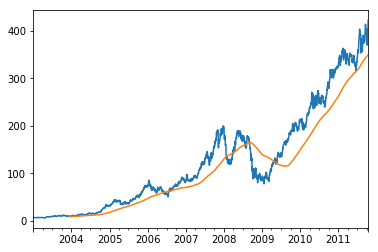

In [119]:
% matplotlib inline

close_px['AAPL'].plot()
close_px.AAPL.rolling(250).mean().plot()

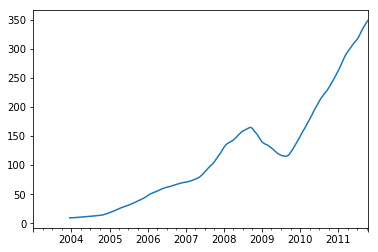

In [120]:
close_px.AAPL.rolling(250, min_periods=250).mean().plot()

要计算扩展窗口平均（expanding window mean），可以使用**expanding方法**而不是rolling。“扩展”意味着，从时间序列的起始处开始窗口，增加窗口直到它超过所有的序列。apple_std250时间序列的扩展窗口平均如下所示：

对DataFrame调用rolling_mean（以及与之类似的函数）会将转换应用到所有的列上（见图11-6）：

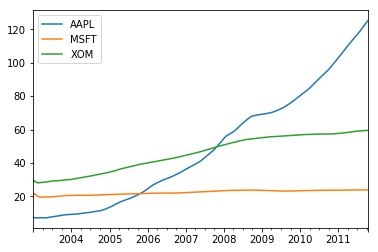

In [121]:
expanding_mean = close_px.expanding().mean()
expanding_mean.plot()

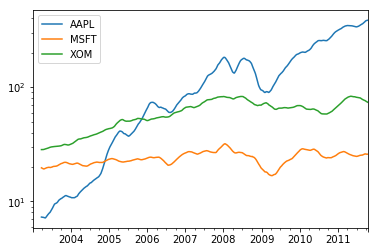

In [122]:
close_px.rolling(60).mean().plot(logy=True)

rolling函数也可以接受一个指定**固定大小时间补偿字符串**，而不是一组时期。这样可以方便处理不规律的时间序列。这些字符串也可以传递给resample。例如，我们可以计算20天的滚动均值，如下所示：

In [123]:
close_px.rolling('20D').mean()

,AAPL,MSFT,XOM
2003-01-02,7.400000,21.110000,29.220000
2003-01-03,7.425000,21.125000,29.230000
2003-01-06,7.433333,21.256667,29.473333
2003-01-07,7.432500,21.425000,29.342500
2003-01-08,7.402000,21.402000,29.240000
2003-01-09,7.391667,21.490000,29.273333
2003-01-10,7.387143,21.558571,29.238571
2003-01-13,7.378750,21.633750,29.197500
2003-01-14,7.370000,21.717778,29.194444
2003-01-15,7.355000,21.757000,29.152000


# 指数加权函数

另一种使用固定大小窗口及相等权数观测值的办法是，定义一个衰减因子（decay factor）常量，以便使近期的观测值拥有更大的权数。衰减因子的定义方式有很多，比较流行的是使用时间间隔（span），它可以使结果兼容于窗口大小等于时间间隔的简单移动窗口（simple moving window）函数。

由于指数加权统计会赋予近期的观测值更大的权数，因此相对于等权统计，它能“适应”更快的变化。

除了rolling和expanding，pandas还有**ewm方法**。下面这个例子对比了苹果公司股价的30日移动平均和span=30的指数加权移动平均（如图11-7所示）：


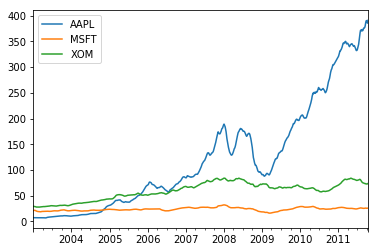

In [124]:
close_px.ewm(span=30).mean().plot()

# 二元移动窗口函数

有些统计运算（如相关系数和协方差）需要在两个时间序列上执行。例如，金融分析师常常对某只股票对某个参考指数（如标准普尔500指数）的相关系数感兴趣。要进行说明，我们先计算我们感兴趣的时间序列的百分数变化：

调用rolling之后，corr聚合函数开始计算与spx_rets滚动相关系数（结果见图11-8）：

假设你想要一次性计算多只股票与标准普尔500指数的相关系数。虽然编写一个循环并新建一个DataFrame不是什么难事，但比较啰嗦。其实，只需传入一个TimeSeries和一个DataFrame，rolling_corr就会自动计算TimeSeries（本例中就是spx_rets）与DataFrame各列的相关系数。结果如图11-9所示：

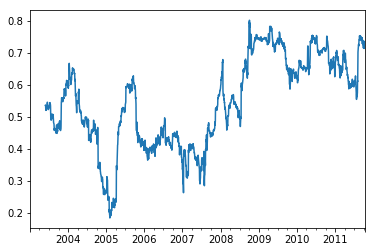

In [125]:
returns  = close_px.pct_change()
corr = returns['AAPL'].rolling(125, min_periods=100).corr(close_px_all['SPX'].pct_change()) 
corr.plot()

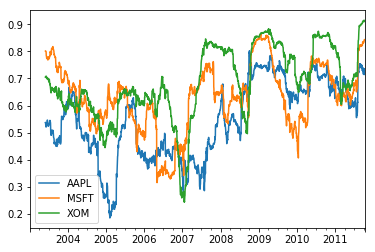

In [126]:
corr = returns.rolling(125, min_periods=100).corr(close_px_all['SPX'].pct_change())
corr.plot()

# 用户定义的移动窗口函数

**rolling结合apply函数**使你能够在移动窗口上应用自己设计的数组函数。唯一要求的就是：该函数要能从数组的各个片段中产生单个值（即约简）。

比如说，当我们用rolling(...).quantile(q)计算样本分位数时，可能对样本中特定值的百分等级感兴趣。scipy.stats.percentileofscore函数就能达到这个目的（结果见图11-10）

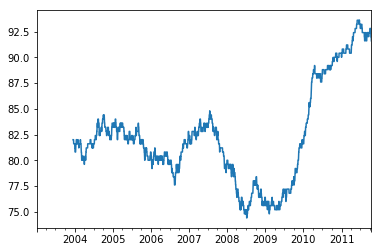

In [127]:
from scipy.stats import percentileofscore

score_at_2percent = lambda x: percentileofscore(x, 0.02)
result = returns['AAPL'].rolling(250).apply(score_at_2percent)
result.plot()